In [12]:
import numpy as np
import pandas as pd
import psycopg2

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.style
matplotlib.style.use('ggplot')
%matplotlib inline

In [13]:
# create a database connection
sqluser = 'mimic'
dbname = 'mimic'
schema_name = 'mimiciii'

cur = None

In [14]:
if cur: 
    cur.close()
    con.close()

con = psycopg2.connect(dbname = dbname, user = sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [15]:
query = \
"""
select * from icu_features;
"""
icu_features = pd.read_sql_query(query, con)
icu_features.head()

,icustay_id,hadm_id,subject_id,age,gender,height,weight,ethnicity,insurance,filter_vaso,...,pc_bronch,pc_cath,pc_echo,pc_pressor,pc_rhc,pc_thora,pc_vent,passed_filters,use_record,bmi
0,200001,152234,55973,22290 days 19:06:12,F,167.851667,27.669135,ASIAN - ASIAN INDIAN,Medicare,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,9.820741
1,200003,163557,27513,17625 days 19:50:04,M,177.800000,78.224998,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,24.744692
2,200006,189514,10950,19736 days 11:28:14,M,165.100000,82.400002,OTHER,Medicaid,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.229647
3,200007,129310,20707,15818 days 10:03:37,M,177.800000,126.000000,WHITE,Private,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.857223
4,200009,129607,29904,17353 days 10:34:32,F,160.020000,85.833331,WHITE,Private,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,33.520264


In [16]:
icu_features_ = icu_features.loc[icu_features['use_record'] == 1]

In [17]:
echo_columns = ['ea_tv_pulm_htn',
    'ea_tv_regurgitation',
    'ea_tv_stenosis',
    'ea_lv_cavity',
    'ea_lv_diastolic',
    'ea_lv_systolic',
    'ea_lv_wall',
    'ea_rv_cavity',
    'ea_rv_volume_overload',
    'ea_rv_systolic',
    'ea_rv_wall',
    'ea_av_regurgitation',
    'ea_av_stenosis',
    'ea_mv_regurgitation',
    'ea_mv_stenosis',
    'ea_la_cavity',
    'ea_ra_dilated',
    'ea_ra_pressure'
]

In [18]:
icu_features_[echo_columns].isnull().sum(axis = 0)

ea_tv_pulm_htn           6500
ea_tv_regurgitation      6131
ea_tv_stenosis           6930
ea_lv_cavity             5976
ea_lv_diastolic          8928
ea_lv_systolic           6064
ea_lv_wall               6173
ea_rv_cavity             5939
ea_rv_volume_overload    8959
ea_rv_systolic           5979
ea_rv_wall               8801
ea_av_regurgitation      6417
ea_av_stenosis           6548
ea_mv_regurgitation      6313
ea_mv_stenosis           7723
ea_la_cavity             6078
ea_ra_dilated            6724
ea_ra_pressure           9020
dtype: int64

In [19]:
ef = icu_features_.copy()

In [20]:
ea_lv_systolic = icu_features_['ea_lv_systolic']

(((ea_lv_systolic < -1) | (ea_lv_systolic.isnull()) & ~icu_features_['ea_key'].isnull())).value_counts()

False    8789
True      531
dtype: int64

In [21]:
echo_columns = ['ea_tv_pulm_htn',
    'ea_tv_regurgitation',
    'ea_tv_stenosis',
    'ea_lv_cavity',
    'ea_lv_diastolic',
    'ea_lv_systolic',
    'ea_lv_wall',
    'ea_rv_cavity',
    #'ea_rv_volume_overload',
    'ea_rv_systolic',
    'ea_rv_wall',
    'ea_av_regurgitation',
    'ea_av_stenosis',
    'ea_mv_regurgitation',
    'ea_mv_stenosis',
    'ea_la_cavity',
    'ea_ra_dilated',
    'ea_ra_pressure'
]

new_echo_columns = []
for ec in echo_columns: 
    ec_ = ec.split('ea_')[1]
    missing = (((ef[ec] == -3) | np.isnan(ef[ec])) & ~np.isnan(ef['ea_key'])).astype(float)
    normal = (ef[ec] == 0).astype(float)
    abnormal = ((ef[ec] == -1) | (ef[ec] == -2) | (ef[ec] > 0)).astype(float)
    ef['{}_missing'.format(ec_)] = missing
    ef['{}_normal'.format(ec_)] = normal
    ef['{}_abnormal'.format(ec_)] = abnormal
    new_echo_columns.extend(['{}_missing'.format(ec_), '{}_normal'.format(ec_), '{}_abnormal'.format(ec_)])

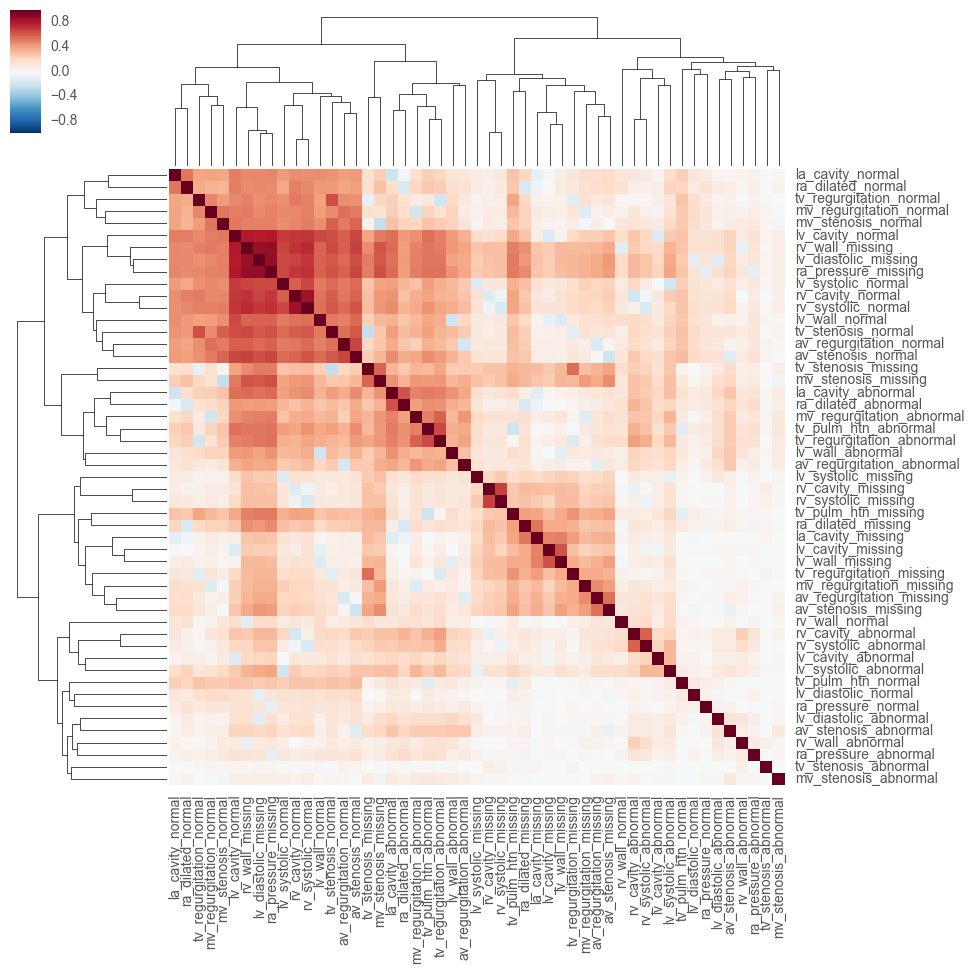

In [23]:
plt.figure(figsize = (12, 12))
g = sns.clustermap(ef[new_echo_columns].corr())
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation = 0)

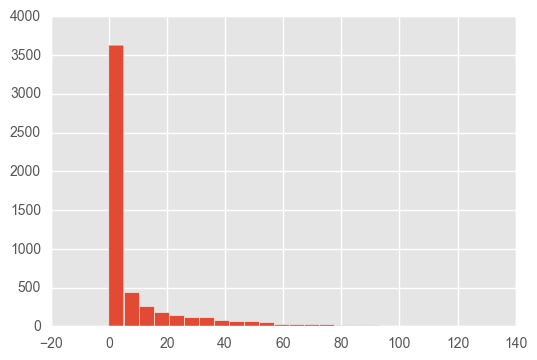

In [48]:
((icu_features_.dod - icu_features_.intime) / np.timedelta64(30, 'D')).hist(bins = 25)

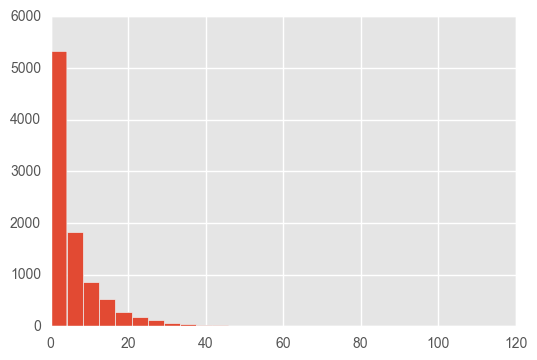

In [47]:
((icu_features_.outtime - icu_features_.intime) / np.timedelta64(1, 'D')).hist(bins = 25)

In [50]:
icu_features_['ea_key'].isnull().value_counts()

True     5634
False    3686
Name: ea_key, dtype: int64